In [ ]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import json
import pickle
from sklearn.neighbors import NearestNeighbors
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors

## Load smk data

We load the SMK data + metadata in a couple of different formats:

- df: Pandas DataFrame with SMK metadata on paintings (i.e., smk type "Maleri", "Akvarel", "Miniature" and "Gouache"). It's mainly "Maleri" in this category, though.

- metadata: JSON file with *all* metadata from the SMK API, not structured (indices match pickle file)

- ds: HuggingFace dataset with same columns as pandas DF, but also a column storing a PIL image of the painting (mainly used here as it's easy to check the painting when it's stored in a ds)

In [37]:
# read df from pickle 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'all_paintings_subset.pkl'))
df.head() # inspect dataframe

smk_id     period  start_year  \
0  KKSgb20565  1803-1861        1803   
1  KKSgb18206  1778-1841        1778   
2  KKSgb17569  1799-1860        1799   
3  KKSgb17570  1799-1860        1799   
4  KKSgb17568  1799-1860        1799   

                                               title  \
0  Udsigt fra Rundetårn over København til Freder...   
1                                     Mand med slæde   
2                                      Eksotisk fugl   
3                                      Eksotisk fugl   
4                                               Fugl   

                          first_artist                            all_artists  \
0                          H.G.F. Holm                          [H.G.F. Holm]   
1  Sigmund Ferdinand Ritter von Perger  [Sigmund Ferdinand Ritter von Perger]   
2         Johan Christian Ernst Walter         [Johan Christian Ernst Walter]   
3         Johan Christian Ernst Walter         [Johan Christian Ernst Walter]   
4         Johan Christian Ernst Walter         [Johan Christian Ernst Walter]   

   num_artists main_type           all_types  \
0            1   Akvarel  [Akvarel, Tegning]   
1            1   Akvarel  [Akvarel, Tegning]   
2            1   Gouache  [Gouache, Tegning]   
3            1   Gouache  [Gouache, Tegning]   
4            1   Gouache  [Gouache, Tegning]   

                                     image_thumbnail  ... num_creators  \
0  https://iip-thumb.smk.dk/iiif/jp2/w3763b937_kk...  ...            1   
1  https://iip-thumb.smk.dk/iiif/jp2/ws859k68q_kk...  ...            1   
2  https://iip-thumb.smk.dk/iiif/jp2/np193f181_kk...  ...            1   
3  https://iip-thumb.smk.dk/iiif/jp2/hm50tx28p_kk...  ...            1   
4  https://iip-thumb.smk.dk/iiif/jp2/pc289p10p_kk...  ...            1   

                                    techniques  \
0                        [Blyant og vandfarve]   
1  [Blyant, pensel, akvarel, pen og sort blæk]   
2                                    [Gouache]   
3                                    [Gouache]   
4                                    [Gouache]   

                                      enrichment_url content_person has_text  \
0  https://enrichment.api.smk.dk/api/enrichment/K...           <NA>     <NA>   
1  https://enrichment.api.smk.dk/api/enrichment/K...           <NA>     <NA>   
2  https://enrichment.api.smk.dk/api/enrichment/K...           <NA>     <NA>   
3  https://enrichment.api.smk.dk/api/enrichment/K...           <NA>     <NA>   
4  https://enrichment.api.smk.dk/api/enrichment/K...           <NA>     <NA>   

                                              colors          geo_location  \
0               [#d7eac3, #888888, #cccccc, #5a5527]  55.681347,12.5757299   
1  [#b7ac3e, #fcaa6b, #ffffff, #222222, #fff1dc, ...                  <NA>   
2  [#fefcdf, #fff1dc, #d73b2e, #888888, #b93530, ...                  <NA>   
3               [#fff1dc, #ffe7c9, #77733d, #140817]                  <NA>   
4  [#fff1dc, #f0f3c7, #fefcdf, #956830, #3a351f, ...                  <NA>   

    entropy                                            tags_en  \
0  9.284325  [building, sky, text, sketch, art, drawing, pa...   
1  9.679977  [animal, sketch, drawing, child art, reptile, ...   
2  9.165382  [animal, sketch, drawing, bird, child art, pai...   
3  9.195556  [animal, sketch, drawing, bird, child art, pai...   
4   8.19523    [animal, sketch, drawing, bird, painting, text]   

                                               image  
0  {'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...  
1  {'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...  
2  {'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...  
3  {'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...  
4  {'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...  

[5 rows x 26 columns]

In [38]:
# load metadata json
json_path = os.path.join(data_path, 'all_paintings_metadata')

# Open and read the JSON file
with open(json_path, 'r') as file:
    metadata = json.load(file)

In [39]:
# load huggingface ds with image data
ds = load_dataset("louisebrix/smk_all_paintings", split="train") # all the data is in the 'train' split

In [40]:
# add column to dataframe with greyscale information from ds (i.e., whether the image is greyscale or not)
df['rgb'] = ds['rgb']

### Add embeddings column

Adding both embeddings from greyscaled image as well as colored

In [41]:
# load embeddings
embeddings = np.load(os.path.join(data_path, 'eva02_clip_all_paintings.npy'))
embeddings.shape # inspect shape

(2085, 1024)

In [42]:
# load greyscaled embeddings
grey_embeddings = np.load(os.path.join(data_path, 'GREY_eva02_clip_all_paintings.npy'))
grey_embeddings.shape

(2085, 1024)

In [43]:
# converting to list of arrays to add to df
embeddings_list = list(embeddings)
grey_embeddings_list = list(grey_embeddings)
df['embedding'] = embeddings_list
df['grey_embedding'] = grey_embeddings_list

In [45]:
# ensuring embeddings are still np arrays and has the correct shape
print(type(df['embedding'].iloc[0]))
print(df['embedding'].iloc[0].shape)
print(type(df['grey_embedding'].iloc[0]))
print(df['grey_embedding'].iloc[0].shape)

<class 'numpy.ndarray'>
(1024,)
<class 'numpy.ndarray'>
(1024,)


### Filter dataframes for paintings only

For this analysis, we are only interested in oil paintings: filtering the dataset to extract these

In [46]:
df = df.query('main_type == "Maleri"')
indices = df.index.tolist()
df.reset_index(drop=True, inplace=True)
ds = ds.select(indices)

# select metadata based on indices
metadata = [metadata[i] for i in indices]

In [47]:
len(df)

1690

### Add column to ds with greyscaled images (for visualization purposes)

In [48]:
import cv2 
from PIL import Image

grey_images = []

feature = Image_ds(decode=False)

for i in tqdm(range(len(ds))):
    image = ds[i]['image']
    image_greyscale = image.convert('L')
    image_encoded = feature.encode_example(image_greyscale) # in order to add an image to a HF dataset column, the image needs to be encoded properly
    grey_images.append(image_encoded)

ds = ds.add_column('grey_image', grey_images)
ds = ds.cast_column('grey_image', Image_ds(decode=True))

# add encoded column to dataframe as well

df['grey_image'] = grey_images

100%|██████████| 1690/1690 [04:53<00:00,  5.76it/s]


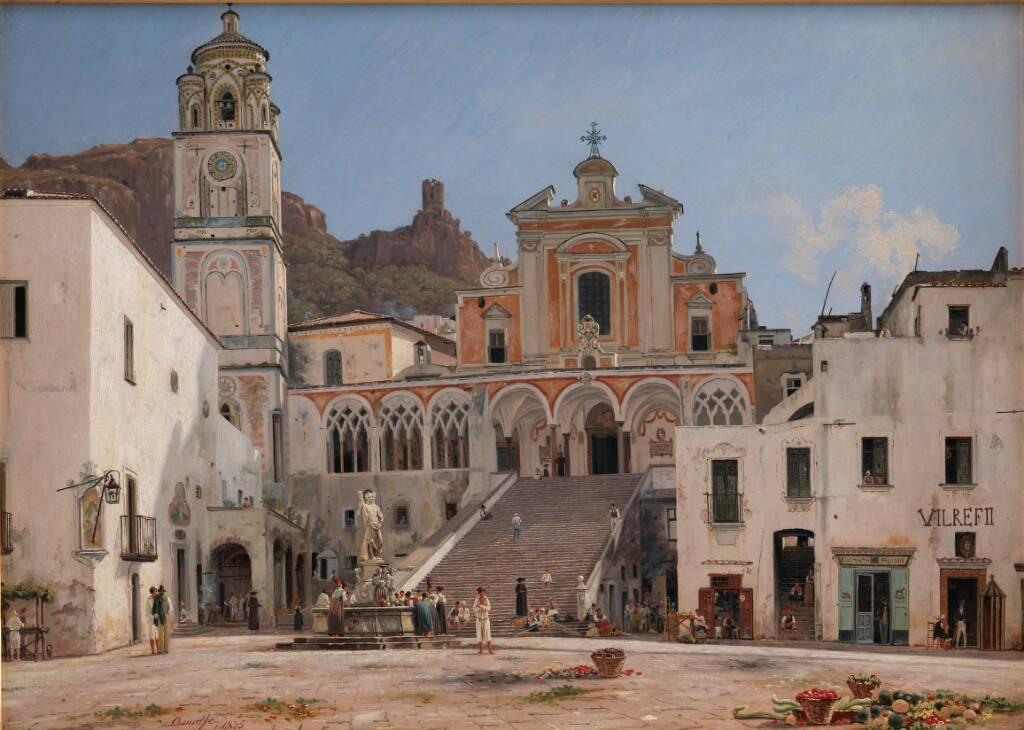

In [49]:
ds[0]['image']

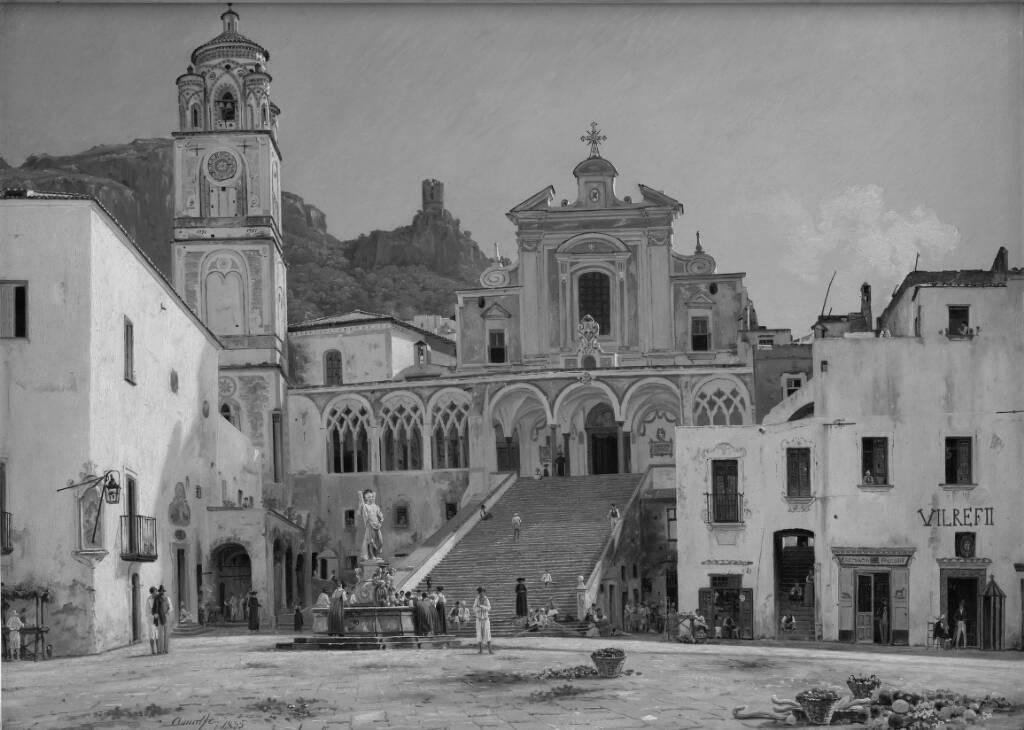

In [50]:
ds[0]['grey_image']

The dataset now only contains paintings and we've added an embeddings column with embeddings from a pre-trained vision model as well as a new column with greyscaled images

### Extract additional information to use for canon definitions

Besides the metadata columns we already have in our df, we need to extract some extra data from the metadata json we can use for defining a canon of paintings and add it to our df:

In [51]:
def extract_canon_info(item):

    ''''
    Get information on canon features from smk item
    '''

    # define relevant keys in metadata dict
    content_keys = ['exhibitions',
                    'acquisition_date', 
                    'responsible_department', 
                    'documentation', 
                    'on_display', 
                    'current_location_name',
                    'literary_reference',
                    'object_history_note']

    content_data = {field: item.get(field, pd.NA) for field in content_keys}

    return content_data

In [52]:
# add extra info to all paintings
data_dicts = []

for item in tqdm(metadata, total=len(metadata)):
    content_data = extract_canon_info(item)
    data_dicts.append(content_data)

data_df = pd.DataFrame(data_dicts)
df = pd.concat([df, data_df], axis=1)

100%|██████████| 1690/1690 [00:00<00:00, 340035.20it/s]


In [53]:
# define function to extract exhibition venues

def exhb_venues(exhb_dict):
    if exhb_dict is not pd.NA:
        venues = []
        for i in range(len(exhb_dict)):
            venue = exhb_dict[i].get('venue', pd.NA)
            venues.append(venue)
        return venues
    
    else:
        return pd.NA

# add column with list of exhibition venues for each painting
venues_list = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]
df['exhibition_venues'] = venues_list

Next, we're checking which paintings have been exhibited at SMK. If that is the case, the venue will be 'Sølvgade' (the adress of SMK in Copenhagen):

In [54]:
def check_smk(venues):
    if isinstance(venues, list):
        if any(isinstance(v, str) and 'Sølvgade' in v for v in venues):
            return True 
        else:
            return False 
    else:
        return False

# add column to dataframe
smk_exhibitions = [check_smk(venues) for venues in df['exhibition_venues']]
df['smk_exhibitions'] = smk_exhibitions

Adding column on exhibition years:

In [55]:
def get_ex_years(ex_dict_list):
    
    dates = []
    if isinstance(ex_dict_list, list):
        
        for e in ex_dict_list:
            start_date = e.get('date_start', None)

            if start_date:
                start_year = start_date.split('-')[0]
                dates.append(start_year)
            else:
                dates.append(pd.NA)
        
    else:
        dates = pd.NA
    
    return dates

ex_dates = [get_ex_years(ex_dict_list) for ex_dict_list in df['exhibitions']]
df['ex_years'] = ex_dates

For the general exhibitions, we are only interested in labelling those which have been exhibited in the 21st century as canon:

In [56]:
exb_canon = []

for idx, row in df.iterrows():
    exb_years = row['ex_years']

    if isinstance(exb_years, list):
        match = False
        for year in exb_years:
            if year.startswith('2') == True:
                match = True
                break
            
            else:
                continue

        if match == True:
            exb_canon.append('canon')
        
        else:
            exb_canon.append('other')

    else:
        exb_canon.append('other')

df['exb_canon'] = exb_canon

In [57]:
# convert columns to canon / other instead of 0/1 or true/false
df['smk_exhibitions'] = df['smk_exhibitions']*1
df['on_display'] = df['on_display']*1

columns = ['exb_canon', 'on_display', 'smk_exhibitions']

for column in columns:
    df[column] = df[column].replace({0: 'other', 1: 'canon'})

## Cleaning data

We need to do some additional data cleaning:

### Removing outliers

There are some objects that do not look like they are from the Golden Age - to look for more outliers, we run a kNN algorithm to find similar 'modern' paintings:

/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/canon-paintings-smk/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/canon-paintings-smk/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/au672746/Library/CloudStorage/OneDrive-Aarhusuniversitet/CHC/canon-paintings-smk/env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


0    1448
1     420
2     704
3    1608
4    1040
5     527
6     709
7      62
8      60
Name: index, dtype: int64


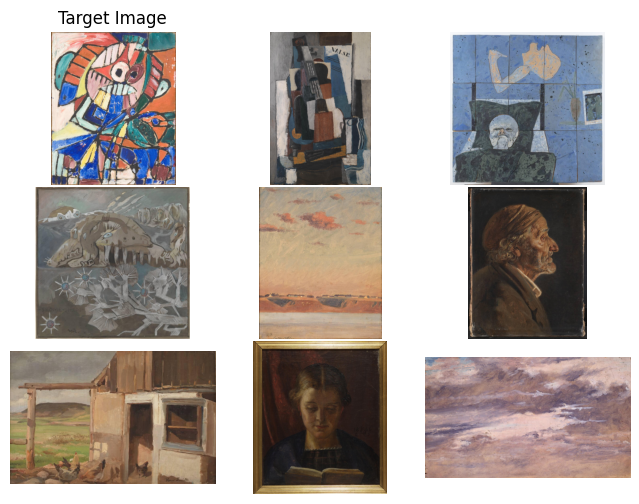

In [58]:
feature_list = np.array(df['embedding'].tolist())
plot_neighbors(feature_list, 661, ds) # choose target image I know is abstract art, not golden age

The first three paintings look a bit strange:

In [59]:
print(df['birth_death'].iloc[661])
print(df['birth_death'].iloc[1448])

['1913-2007']
['1883-1941']


We can remove these paintings - they do not look like they are from the Golden Age and the artists behind them was not born during this time period. Seems like a mistake in SMK's database.

The third painting is a bit more difficult: it does not look like a painting from the Golden Age, even though the time period says so. I have a suspicion that the painting and the metadata do not match:

Landskab med muldyr og geder


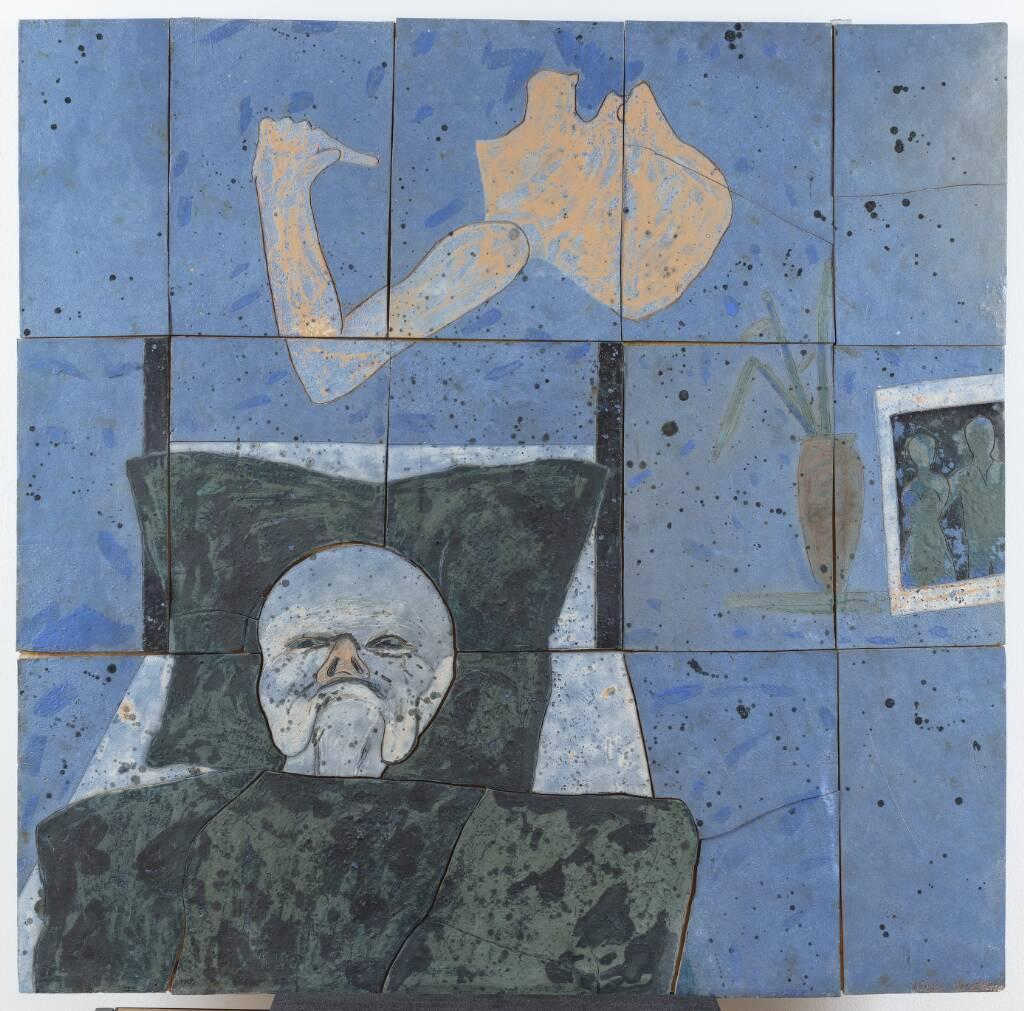

In [60]:
print(df['title'].iloc[420]) # this does not look like a 'landskab med muldyr og geder' (landscape with mules and goats)
ds[420]['image']

In [61]:
# removing the three non-GA paintings from all datasets
idx_to_remove = [661, 1448, 420]
df = df.drop(idx_to_remove)

# align metadata dicts and image dataset with df
metadata = [metadata[i] for i in df.index.tolist()]

ds_new = ds.select(df.index.tolist())

# reset index of df
df.reset_index(drop=True, inplace=True)

## Fix inconsistencies in dating

Some of the paintings have long production periods, even up to 129 years. As we want to work with a single production date, we need to find a way to make the production dates more concrete:


We extract the paintings with long production periods and save them to a csv with more information about their production date:

In [62]:
# get range of production periods
diff_list = []
for idx, row in df.iterrows():

    if '-' in row['period']:
        start_year = int(row['period'].split('-')[0])
        end_year = int(row['period'].split('-')[-1])
        diff = end_year - start_year

        diff_list.append(diff)
    
    # if production period is just a single year, assign 0
    else:
        diff_list.append(0)

# save to df
df['prod_diff'] = diff_list

# get notes on 'production_date' from our metadata with all SMK's data 
prod_notes = [dict.get('production_dates_notes', pd.NA) for dict in metadata]
df['prod_notes'] = prod_notes

In [63]:
# create df with relevant variables and save to csv
prod_df = df.query('prod_diff > 20')[['period', 'prod_diff', 'prod_notes', 'birth_death', 'first_artist', 'smk_id']]
prod_df.to_csv(os.path.join(data_path, 'long_prod_paintings.csv'))

We use this csv file to manually update the dating for some of the paintings with a production period of +20 years. We update the dataframe with these results:

In [64]:
prod_df = pd.read_csv(os.path.join(data_path, 'long_prod_periods_ingeborg.csv'), encoding='latin1')

In [65]:
# making some manual additions to the new df (the new prod date was defined as a period)
prod_df.loc[0, 'Estimated production date'] = 1917
prod_df.loc[1, 'Estimated production date'] = 1875
prod_df.loc[130, 'Estimated production date'] = 1880
prod_df.loc[140, 'Estimated production date'] = 1833

In [66]:
# create new variable to update with new production years
df['prod_year'] = df['start_year']

# Merge new prod_df with old df by SMK ID
df_merged = df.merge(prod_df[['smk_id', 'Estimated production date']], on='smk_id', how='left')

# Update rows in dataframe where there is a new start date
df_merged['prod_year'] = df_merged['Estimated production date'].combine_first(df_merged['prod_year'])

For those paintings with a production period of 2-19 years, we just take the mean of the production period:

In [67]:
period_df = df_merged.query("prod_diff > 2")
period_nans = period_df[period_df['Estimated production date'].isna()] # for all of the rows with a production period where the year was not manually set, take the mean prod year:

for idx, row in period_nans.iterrows():
    start_year = int(row['period'].split('-')[0])
    end_year = int(row['period'].split('-')[1])
    period_nans.loc[idx, 'Estimated production date'] = (start_year + end_year) // 2

In [68]:
# Now update 'prod_year' with the corrected 'Estimated production date' where available
df_temp = df_merged.merge(
    period_nans[['smk_id', 'Estimated production date']],
    on='smk_id',
    how='left',
    suffixes=('', '_corrected')  # 
)

df_temp['prod_year'] = df_temp['Estimated production date_corrected'].combine_first(df_temp['prod_year'])

In [69]:
# update prod years in dataframe
df['prod_year'] = df_temp['prod_year']
df['prod_year'] = pd.to_numeric(df['prod_year'], errors='coerce')

Now that we've updated some of the years, we need to remove those dated beyond our period definition:

In [70]:
df_new_prod_years = df.copy()
df_new_prod_years['start_year'] = df_new_prod_years['prod_year']
df_new_prod_years_filtered = df_new_prod_years[df_new_prod_years['prod_year'] <= 1870]

# save indices of 'old' df: 
indices = df_new_prod_years_filtered.index.tolist()

# reset index for new df to start from 0
df_new_prod_years_filtered.reset_index(drop=True, inplace=True)

In [71]:
# only keep relevant paintings in metadata
metadata = [metadata[i] for i in indices]

In [79]:
# create total canon/non-canon variable
total_canon = []
for idx, row in df_new_prod_years_filtered.iterrows():
    if (
        row['exb_canon'] == 'canon' or
        row['smk_exhibitions'] == 'canon' or
        row['on_display'] == 'canon'
    ):
        total_canon.append('canon')
    else:
        total_canon.append('other')
df_new_prod_years_filtered['total_canons'] = total_canon

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_54669/1585169625.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_prod_years_filtered['total_canons'] = total_canon


In [81]:
# write new df to pickle
df_new_prod_years_filtered.to_pickle(os.path.join(data_path, 'smk_canon_paintings.pkl')) 

In [82]:
# save metadata dicts
with open(os.path.join(data_path, 'smk_canon_paintings_metadata'), "w") as json_file:
    json.dump(metadata, json_file, indent=2)

In [83]:
# create new HF dataset with updated canon + start year variables
updated_ds = Dataset.from_pandas(df_new_prod_years_filtered)

# decode images column from raw bytes back to PIL images
updated_ds = updated_ds.cast_column('image', Image_ds(decode=True))
updated_ds = updated_ds.cast_column('grey_image', Image_ds(decode=True)) 

# save HF dataset to data folder
updated_ds.save_to_disk(os.path.join(data_path, 'smk_canon_paintings'))

Saving the dataset (3/3 shards): 100%|██████████| 1656/1656 [00:03<00:00, 502.03 examples/s]


The above code chunk saves the HuggingFace dataset to the local /data folder. We also upload it to the HuggingFace hub. Find link to the dataset via the main README file